<a href="https://colab.research.google.com/github/Smetankin927/STM32/blob/main/UnetRunned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem 2. Segmentation. (40 pts)

In this task, your challenge is to perform semantic segmentation on images from the [PASCAL Visual Object Classes (VOC)](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html) dataset. The PASCAL VOC dataset is a well-known dataset in computer vision that includes images of 20 object categories with annotations for classification, detection, and segmentation tasks. Your objective is to develop a segmentation model capable of accurately identifying and delineating multiple object categories within an image, such as animals, vehicles, and household objects. Download the training/validation data (2GB tar file). All the images are shared in the folder "JPEGImages", and the annotated images are available under the "SegmentationObject" folder. Use the [train.txt](https://drive.google.com/file/d/1upvDgz5cU6A3S7GR17huuqVbmAcj0Aeu/view?usp=sharing) and [test.txt](https://drive.google.com/file/d/19KBwTTN8h9z_LJnfD74mp6_OmPFRSZ4j/view?usp=sharing) files for training and testing your model.

Please follow these guidelines and requirements:

- You may consider resizing images to a manageable resolution (e.g., 512x512 pixels) to streamline the experimentation process. Utilize a standard train-test split as recommended for the PASCAL VOC dataset.
- **(20 pts)** Implement the necessary components of the train-test pipeline, including dataset preparation, model (You can use predefined architectures like Unet), model training, and testing. Assess your model's performance on the test dataset.
  - **(10 pts) Bonus:** your own model, not taken from libraries and not a Unet.
- **(5 pts)** Compute and report the Intersection over Union (IoU) and Dice scores for each category on the test set.
- **(5 pts)** Incorporate image augmentations to enhance model accuracy. You may find augmentation libraries such as Albumentations or Kornia beneficial for this purpose.
- **(2 pts)** Exhibit 4-6 examples of your segmentation results on the test dataset, showcasing the best and worst results based on loss/metrics.
- **(3 pts)** Thoroughly explain your methodological approach to this task. Describe the experiments you conducted, their outcomes, and the reasoning behind your decisions. Evaluate the appropriateness of the metrics you used.
- **(5 pts)** Create a function for model inference that accepts an image path. Verify your model's effectiveness on several external images not from the dataset, to gauge its generalizability.
- Refrain from using models that are pre-trained on the PASCAL VOC dataset to maintain the integrity of the competition.
- **Bonus Points:**
  - **+10 points** for attaining the top-1 result.
  - **+8 points** for achieving 2nd or 3rd place.
  - **+5 points** for ranking 4th to 8th, based on the reported mean Dice score on your chosen test split.


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
from typing import Tuple

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import helper

In [ ]:
NUM_CLASSES = 20
DEVICE = "cuda"
LR = 1e-3
EPOCHS = 25

IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

BATCH_SIZE = 16

MEAN = [0.485, 0.456, 0.406] #[0.0, 0.0, 0.0] #
STD =  [0.229, 0.224, 0.225] #[1.0, 1.0, 1.0] #[

LOSS_FN = nn.CrossEntropyLoss()

# def softmax_cross_entropy_with_logits(labels, logits, dim=-1):
#     return (-labels * F.log_softmax(logits, dim=dim)).sum(dim=dim)


In [ ]:
TRAIN_IMG_DIR = "drive/MyDrive/trainData/"
TRAIN_MASK_DIR = "drive/MyDrive/train/"
VAL_IMG_DIR = "drive/MyDrive/testData"
VAL_MASK_DIR = "drive/MyDrive/subset/"

In [ ]:
test_code = []
with open('test.txt') as fobj:
    for line in fobj:
        row = line.split()
        test_code.append(row)

train_code = []
with open('train.txt') as fobj:
    for line in fobj:
        row = line.split()
        train_code.append(row)

test_mask = [item[0]+".png" for item in test_code]
test_img = [item[0]+".jpg" for item in test_code]

train_mask = [item[0]+".png" for item in train_code]
train_img = [item[0]+".jpg" for item in train_code]

In [ ]:
os.listdir(TRAIN_IMG_DIR);

In [ ]:
train_img_paths = [os.path.join(TRAIN_IMG_DIR, path) for path in train_img]
train_mask_paths = [os.path.join(TRAIN_MASK_DIR, path) for path in train_mask]

test_img_paths = [os.path.join(VAL_IMG_DIR, path) for path in test_img]
test_mask_paths = [os.path.join(VAL_MASK_DIR, path) for path in test_mask]



In [ ]:
# test_ratio = 0.25
# concatenate
# all_img_paths = [*ai_paths, *real_paths]
# all_labels = [*ai_labels, *real_labels]

# train_img_paths, test_img_paths, train_labels, test_labels = train_test_split(
#     all_img_paths, all_labels, test_size=0.25, random_state=42
# )

drive/MyDrive/trainData/2007_000032.jpg
drive/MyDrive/trainData/2007_000039.jpg
drive/MyDrive/trainData/2007_000063.jpg
drive/MyDrive/trainData/2007_000068.jpg


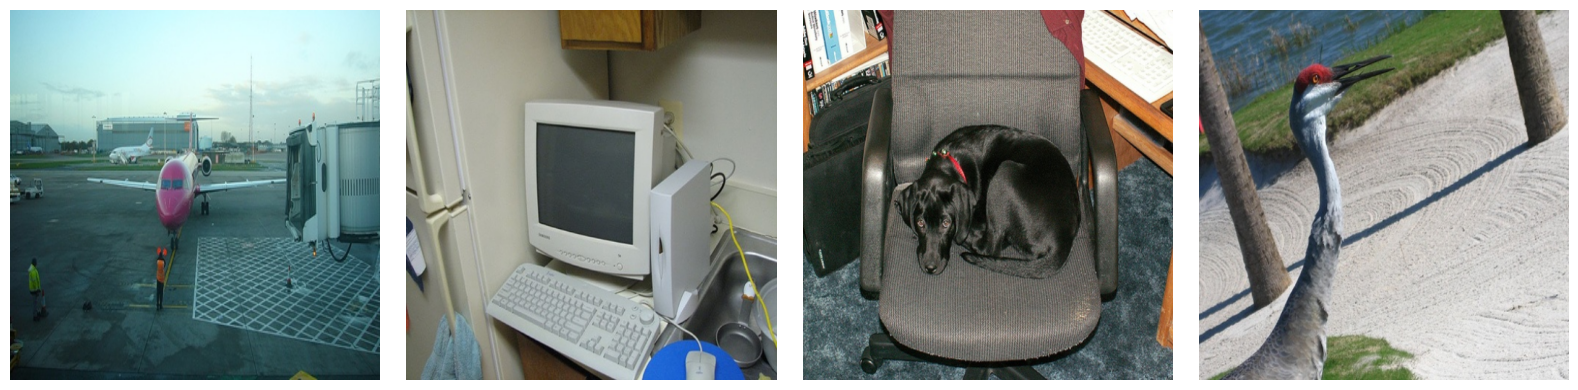

In [ ]:
resize = T.Resize((IMG_SIZE, IMG_SIZE))

fig, ax = plt.subplots(ncols=4, figsize=(4 * 4, 4))
for i in range(4):
    img = Image.open(train_img_paths[i])
    print(train_img_paths[i])
    ax[i].imshow(resize(img))
    ax[i].axis('off')
fig.tight_layout()

drive/MyDrive/train/2007_000032.png
drive/MyDrive/train/2007_000039.png
drive/MyDrive/train/2007_000063.png
drive/MyDrive/train/2007_000068.png


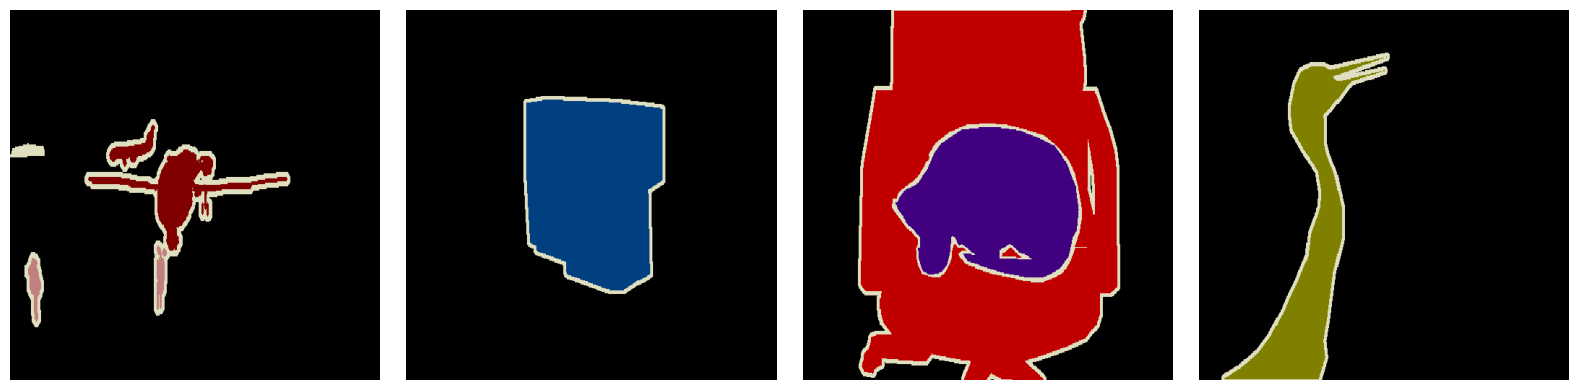

In [ ]:
resize = T.Resize((IMG_SIZE, IMG_SIZE))

fig, ax = plt.subplots(ncols=4, figsize=(4 * 4, 4))
for i in range(4):
    img = Image.open(train_mask_paths[i])
    print(train_mask_paths[i])
    ax[i].imshow(resize(img))
    ax[i].axis('off')
fig.tight_layout()

Albumentations

In [ ]:
import albumentations as A
import albumentations.pytorch as AP
def get_train_alb():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Normalize(
          mean = MEAN,
          std = STD,
          max_pixel_value = 255.0
      ),
      AP.ToTensorV2()
  ])
def get_val_alb():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.Normalize(
          mean = MEAN,
          std = STD,
          max_pixel_value = 255.0
      ),
      AP.ToTensorV2(),
  ])

Dataset

In [ ]:

class Segm_Dataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        # self.images = train_img_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        mask_path = self.mask_paths[index]
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        #  h w c -> c h w
        # image = np.transpose(image, (2,0,1))
        # mask = np.transpose(mask, (2,0,1))


        image = (torch.Tensor(image)/255.0).to(DEVICE)
        mask = torch.round(torch.Tensor(mask)/255.0).to(DEVICE)

        return image, mask

In [ ]:
trainset = Segm_Dataset(train_img_paths, train_mask_paths, transform=get_train_alb())
testset = Segm_Dataset(test_img_paths, test_mask_paths, transform=get_val_alb())


In [ ]:
print(len(trainset))
print(len(testset))


1464
1449


In [ ]:
# fig, ax = plt.subplots(ncols=2, figsize=(4 * 4, 4))
# idx=3
# img, mask = trainset[idx]
# # c h w -> h w c
# # img = np.transpose(img, (2,0,1)).astype(np.float32)
# # mask = np.transpose(mask, (2,0,1)).astype(np.float32)
# ax[0].imshow(mask)
# ax[0].axis('off')

# ax[1].imshow(img)
# ax[1].axis('off')
# fig.tight_layout()
# print(img.shape)

Batch Loader

In [ ]:

trailnloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validlodaer = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print(len(trailnloader))
print(len(validlodaer))

92
91


In [ ]:
# One batch

for image, mask in trailnloader:
  break
print(image.shape)
print(mask.shape)

torch.Size([16, 3, 512, 512])
torch.Size([16, 512, 512])


In [ ]:
# mask.type(torch.LongTensor).shape



Model

In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
from Unet import UNET

In [ ]:
from tqdm import tqdm

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            # print(predictions.shape)
            # print(targets.shape)
            loss = loss_fn(predictions, targets)
            lossDice = DiceLoss(mode = 'multilabel')(predictions, targets)
            lossIoU = JaccardLoss(mode = 'multilabel')(predictions, targets)

            print(f"Dice = {lossDice}")
            print(f"IoU = {lossIoU}")
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


In [ ]:
model = UNET(in_channels=3, out_channels=20).to(DEVICE)
# lossDice = DiceLoss(mode = 'multilabel')
# lossIoU = JaccardLoss(mode = 'multilabel')
scaler = torch.cuda.amp.GradScaler()
loss_fn = LOSS_FN
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
for epoch in range(EPOCHS):
        train_fn(trailnloader, model, optimizer, loss_fn,scaler)

  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:14<22:04, 14.55s/it, loss=0.714]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:29<21:47, 14.53s/it, loss=0.686]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:43<21:48, 14.70s/it, loss=0.711]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:56<20:01, 13.66s/it, loss=0.698]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [01:08<19:22, 13.36s/it, loss=0.627]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [01:23<20:00, 13.96s/it, loss=0.633]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [01:37<19:44, 13.94s/it, loss=0.766]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [01:52<19:42, 14.08s/it, loss=0.625]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [02:06<19:27, 14.07s/it, loss=0.806]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [02:21<19:36, 14.35s/it, loss=0.716]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [02:36<19:39, 14.56s/it, loss=0.677]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [02:50<19:09, 14.37s/it, loss=0.656]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [03:04<18:52, 14.34s/it, loss=0.619]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [03:18<18:37, 14.33s/it, loss=0.729]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [03:32<17:58, 14.00s/it, loss=0.679]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [03:46<17:59, 14.20s/it, loss=0.651]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [04:01<17:49, 14.26s/it, loss=0.753]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [04:14<17:09, 13.91s/it, loss=0.625]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [04:28<17:06, 14.06s/it, loss=0.581]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [04:42<16:47, 13.99s/it, loss=0.609]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [04:57<17:01, 14.38s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [05:12<16:46, 14.37s/it, loss=0.59]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [05:25<16:10, 14.06s/it, loss=0.624]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [05:40<16:20, 14.41s/it, loss=0.641]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [05:55<16:08, 14.46s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [06:09<15:57, 14.51s/it, loss=0.673]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [06:24<15:51, 14.64s/it, loss=0.612]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [06:40<15:58, 14.98s/it, loss=0.587]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [06:54<15:22, 14.65s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [07:07<14:34, 14.11s/it, loss=0.6]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [07:21<14:20, 14.10s/it, loss=0.647]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [07:34<13:53, 13.89s/it, loss=0.652]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [07:48<13:36, 13.84s/it, loss=0.613]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [08:04<13:51, 14.33s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [08:20<14:12, 14.95s/it, loss=0.655]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [08:33<13:26, 14.40s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [08:49<13:33, 14.79s/it, loss=0.64]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [09:04<13:21, 14.84s/it, loss=0.674]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [09:20<13:37, 15.42s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [09:35<13:12, 15.23s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [09:49<12:36, 14.82s/it, loss=0.637]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [10:04<12:16, 14.73s/it, loss=0.629]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [10:18<12:02, 14.75s/it, loss=0.688]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [10:33<11:50, 14.81s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [10:57<13:33, 17.31s/it, loss=0.661]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [11:12<12:47, 16.69s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [11:25<11:47, 15.72s/it, loss=0.603]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [11:40<11:20, 15.47s/it, loss=0.686]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [11:55<10:54, 15.22s/it, loss=0.596]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [12:09<10:24, 14.87s/it, loss=0.623]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [12:22<09:55, 14.51s/it, loss=0.649]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [12:36<09:32, 14.32s/it, loss=0.569]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [12:51<09:21, 14.40s/it, loss=0.645]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [13:11<10:13, 16.14s/it, loss=0.603]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [13:28<10:01, 16.25s/it, loss=0.613]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [13:42<09:29, 15.82s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [13:57<09:00, 15.46s/it, loss=0.537]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [14:10<08:23, 14.82s/it, loss=0.615]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [14:25<08:07, 14.76s/it, loss=0.635]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [14:39<07:41, 14.41s/it, loss=0.601]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [14:54<07:32, 14.60s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [15:08<07:18, 14.62s/it, loss=0.694]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [15:22<06:52, 14.23s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [15:35<06:28, 13.87s/it, loss=0.702]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [15:50<06:26, 14.31s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [16:04<06:11, 14.29s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [16:19<06:02, 14.51s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [16:34<05:48, 14.53s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [16:47<05:27, 14.22s/it, loss=0.627]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [17:02<05:16, 14.38s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [17:16<04:58, 14.20s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [17:37<05:25, 16.29s/it, loss=0.61]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [17:51<04:53, 15.47s/it, loss=0.569]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [18:05<04:34, 15.22s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [18:23<04:32, 16.02s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [18:38<04:11, 15.73s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [18:53<03:52, 15.48s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [19:08<03:33, 15.25s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [19:22<03:12, 14.79s/it, loss=0.547]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [19:36<02:56, 14.67s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [19:55<02:55, 15.93s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [20:09<02:32, 15.29s/it, loss=0.637]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [20:23<02:15, 15.04s/it, loss=0.526]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [20:38<02:00, 15.09s/it, loss=0.6]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [20:53<01:43, 14.85s/it, loss=0.621]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [21:07<01:28, 14.79s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [21:20<01:11, 14.23s/it, loss=0.622]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [21:34<00:56, 14.09s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [21:48<00:41, 13.99s/it, loss=0.583]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [22:01<00:27, 13.68s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [22:15<00:13, 13.98s/it, loss=0.618]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:41,  2.43s/it, loss=0.482]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:42,  2.47s/it, loss=0.619]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:39,  2.47s/it, loss=0.604]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:39,  2.50s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:37,  2.50s/it, loss=0.491]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:33,  2.48s/it, loss=0.607]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:30,  2.48s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:27,  2.48s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:22<03:27,  2.50s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:23,  2.48s/it, loss=0.652]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:27<03:19,  2.46s/it, loss=0.663]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:16,  2.46s/it, loss=0.663]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:32<03:13,  2.44s/it, loss=0.591]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:11,  2.45s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:07,  2.44s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:39<03:04,  2.43s/it, loss=0.669]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:01,  2.42s/it, loss=0.578]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:44<02:58,  2.41s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:55,  2.41s/it, loss=0.708]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:49<02:54,  2.42s/it, loss=0.559]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:51,  2.41s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:48,  2.41s/it, loss=0.499]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:46,  2.41s/it, loss=0.634]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:43,  2.40s/it, loss=0.596]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:01<02:40,  2.40s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.43s/it, loss=0.659]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:37,  2.42s/it, loss=0.736]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.42s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.42s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:13<02:30,  2.42s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:28,  2.44s/it, loss=0.543]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:18<02:28,  2.47s/it, loss=0.637]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:24,  2.45s/it, loss=0.666]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:23<02:21,  2.44s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.44s/it, loss=0.577]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:17,  2.45s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:15,  2.46s/it, loss=0.621]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:12,  2.45s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:35<02:09,  2.45s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.44s/it, loss=0.596]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:40<02:04,  2.44s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:03,  2.47s/it, loss=0.71]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:45<02:00,  2.46s/it, loss=0.48]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:57,  2.45s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:50<01:55,  2.45s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:52<01:52,  2.44s/it, loss=0.693]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:50,  2.46s/it, loss=0.563]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:57<01:48,  2.47s/it, loss=0.683]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:45,  2.45s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:02<01:42,  2.44s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:39,  2.43s/it, loss=0.648]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:07<01:37,  2.45s/it, loss=0.569]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:09<01:35,  2.45s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:12<01:32,  2.44s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:14<01:29,  2.42s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:27,  2.42s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:19<01:24,  2.41s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:22,  2.43s/it, loss=0.614]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:24<01:20,  2.44s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:17,  2.43s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:14,  2.41s/it, loss=0.626]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:31<01:12,  2.42s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:09,  2.41s/it, loss=0.606]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:36<01:08,  2.43s/it, loss=0.627]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:05,  2.42s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:41<01:02,  2.41s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:43<01:00,  2.42s/it, loss=0.64]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:57,  2.40s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:48<00:55,  2.43s/it, loss=0.583]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.43s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:53<00:50,  2.43s/it, loss=0.6]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.42s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:45,  2.42s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:43,  2.41s/it, loss=0.563]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.44s/it, loss=0.546]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:05<00:38,  2.43s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.42s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:10<00:33,  2.41s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.41s/it, loss=0.609]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.44s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.43s/it, loss=0.6]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.43s/it, loss=0.618]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:22<00:21,  2.42s/it, loss=0.576]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.42s/it, loss=0.706]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:27<00:17,  2.44s/it, loss=0.505]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.46s/it, loss=0.497]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:32<00:12,  2.44s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.43s/it, loss=0.686]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.41s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:39<00:04,  2.41s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.42s/it, loss=0.534]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:39,  2.41s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:34,  2.39s/it, loss=0.457]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:33,  2.39s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:31,  2.40s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:31,  2.43s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:28,  2.42s/it, loss=0.62]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:16<03:25,  2.42s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:22,  2.42s/it, loss=0.548]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:20,  2.42s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:20,  2.44s/it, loss=0.627]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:19,  2.46s/it, loss=0.576]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:15,  2.45s/it, loss=0.528]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.43s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:33<03:09,  2.43s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:06,  2.42s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:04,  2.43s/it, loss=0.611]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:02,  2.43s/it, loss=0.639]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:59,  2.42s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:57,  2.43s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:54,  2.42s/it, loss=0.631]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:50<02:52,  2.43s/it, loss=0.621]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:51,  2.44s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:48,  2.44s/it, loss=0.654]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:45,  2.43s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.42s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.43s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:38,  2.44s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:36,  2.44s/it, loss=0.59]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.42s/it, loss=0.633]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:29,  2.42s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.42s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:26,  2.45s/it, loss=0.662]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:23,  2.43s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.41s/it, loss=0.715]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:24<02:17,  2.42s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.42s/it, loss=0.622]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:13,  2.44s/it, loss=0.635]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.44s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:09,  2.44s/it, loss=0.48]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:05,  2.41s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:41<02:00,  2.41s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.45s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:56,  2.43s/it, loss=0.631]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:53,  2.42s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:51,  2.42s/it, loss=0.518]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:48,  2.41s/it, loss=0.648]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:47,  2.45s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:45,  2.46s/it, loss=0.652]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:42,  2.45s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:39,  2.43s/it, loss=0.631]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.44s/it, loss=0.596]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.42s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:33,  2.45s/it, loss=0.623]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.43s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:27,  2.43s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.42s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:22,  2.41s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.45s/it, loss=0.547]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:18,  2.44s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.44s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.42s/it, loss=0.595]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.42s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.42s/it, loss=0.578]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:05,  2.44s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:02,  2.42s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.42s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:57,  2.41s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.41s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.44s/it, loss=0.662]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.42s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.42s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:45,  2.41s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.41s/it, loss=0.608]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.41s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.43s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:06<00:36,  2.41s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:33,  2.41s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.40s/it, loss=0.613]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:28,  2.41s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.44s/it, loss=0.604]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.43s/it, loss=0.578]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.42s/it, loss=0.652]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:23<00:19,  2.42s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:16,  2.41s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.43s/it, loss=0.434]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.46s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.43s/it, loss=0.451]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.44s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.43s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:40<00:02,  2.43s/it, loss=0.509]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:45,  2.48s/it, loss=0.566]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:41,  2.46s/it, loss=0.65]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:36,  2.43s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:34,  2.43s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:30,  2.42s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:30,  2.45s/it, loss=0.605]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:26,  2.43s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:23,  2.43s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:20,  2.42s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:17,  2.41s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.43s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:15,  2.45s/it, loss=0.61]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:12,  2.43s/it, loss=0.605]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:08,  2.42s/it, loss=0.543]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:06,  2.42s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:02,  2.40s/it, loss=0.48]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:02,  2.43s/it, loss=0.487]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:58,  2.42s/it, loss=0.658]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:56,  2.41s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:53,  2.41s/it, loss=0.636]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:50<02:52,  2.42s/it, loss=0.652]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:53,  2.48s/it, loss=0.446]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:50,  2.48s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:47,  2.46s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:43,  2.43s/it, loss=0.668]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.43s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:36,  2.41s/it, loss=0.393]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.44s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.41s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:28,  2.40s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:26,  2.40s/it, loss=0.595]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:24,  2.40s/it, loss=0.64]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:22,  2.42s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.43s/it, loss=0.621]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:24<02:18,  2.43s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.41s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:12,  2.42s/it, loss=0.638]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:09,  2.41s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:09,  2.45s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.43s/it, loss=0.578]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.482]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:41<02:01,  2.42s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:58,  2.42s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:57,  2.44s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:55,  2.46s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:52,  2.45s/it, loss=0.445]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.43s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.43s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:58<01:44,  2.42s/it, loss=0.42]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:42,  2.45s/it, loss=0.658]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:39,  2.43s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.43s/it, loss=0.614]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.42s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:31,  2.41s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:30,  2.44s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:15<01:27,  2.42s/it, loss=0.651]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.42s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:22,  2.41s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:19,  2.41s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:16,  2.40s/it, loss=0.588]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:14,  2.42s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.41s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:32<01:09,  2.40s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.39s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:04,  2.40s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:02,  2.42s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.41s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:44<00:57,  2.41s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.40s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:49<00:52,  2.40s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.39s/it, loss=0.701]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.42s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:56<00:45,  2.41s/it, loss=0.586]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.41s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:01<00:40,  2.41s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.41s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:06<00:36,  2.42s/it, loss=0.566]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:08<00:33,  2.42s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.41s/it, loss=0.586]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:13<00:28,  2.40s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.41s/it, loss=0.615]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:18<00:24,  2.43s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:22,  2.47s/it, loss=0.407]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:23<00:19,  2.45s/it, loss=0.62]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.44s/it, loss=0.596]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.43s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:30<00:12,  2.43s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.44s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:35<00:07,  2.43s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.42s/it, loss=0.488]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:40<00:02,  2.42s/it, loss=0.58]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:39,  2.41s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:41,  2.46s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:35,  2.43s/it, loss=0.607]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:33,  2.42s/it, loss=0.615]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:29,  2.40s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:28,  2.42s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:30,  2.47s/it, loss=0.657]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:26,  2.46s/it, loss=0.719]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:23,  2.45s/it, loss=0.676]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:19,  2.43s/it, loss=0.635]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:16,  2.42s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:12,  2.41s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:12,  2.44s/it, loss=0.712]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:08,  2.42s/it, loss=0.63]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:05,  2.41s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:02,  2.41s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:00,  2.40s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<03:00,  2.44s/it, loss=0.546]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:58,  2.45s/it, loss=0.684]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:55,  2.44s/it, loss=0.62]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:50<02:51,  2.42s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:49,  2.43s/it, loss=0.559]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:46,  2.42s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:46,  2.45s/it, loss=0.577]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.43s/it, loss=0.639]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:39,  2.42s/it, loss=0.658]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:36,  2.41s/it, loss=0.62]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:07<02:33,  2.40s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:33,  2.44s/it, loss=0.56]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:31,  2.44s/it, loss=0.668]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:28,  2.44s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:25,  2.42s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:23,  2.42s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:19,  2.41s/it, loss=0.472]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:24<02:18,  2.44s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.42s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:12,  2.42s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:10,  2.42s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:07,  2.40s/it, loss=0.47]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.43s/it, loss=0.385]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.43s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:41<02:01,  2.42s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:58,  2.42s/it, loss=0.518]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:56,  2.42s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:53,  2.41s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:52,  2.45s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.43s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.43s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:58<01:43,  2.41s/it, loss=0.64]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:41,  2.42s/it, loss=0.571]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:39,  2.43s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.42s/it, loss=0.571]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.42s/it, loss=0.435]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:10<01:32,  2.42s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.43s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:15<01:27,  2.44s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:26,  2.47s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:23,  2.45s/it, loss=0.517]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.43s/it, loss=0.664]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:17,  2.42s/it, loss=0.603]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.42s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.43s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:32<01:10,  2.43s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.42s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:05,  2.42s/it, loss=0.583]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:02,  2.42s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.44s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:58,  2.46s/it, loss=0.645]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:56,  2.44s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:49<00:53,  2.44s/it, loss=0.621]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.43s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.43s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.45s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.44s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.43s/it, loss=0.517]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.43s/it, loss=0.605]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:06<00:36,  2.42s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:34,  2.45s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.45s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.43s/it, loss=0.473]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.44s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.43s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:22,  2.47s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.47s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.46s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.44s/it, loss=0.509]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.43s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.42s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.44s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.43s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.43s/it, loss=0.553]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:36,  2.38s/it, loss=0.661]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:36,  2.41s/it, loss=0.409]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:37,  2.44s/it, loss=0.56]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:36,  2.46s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:32,  2.44s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:29,  2.43s/it, loss=0.676]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:26,  2.43s/it, loss=0.479]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:24,  2.43s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:24,  2.46s/it, loss=0.587]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:20,  2.44s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.43s/it, loss=0.385]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:13,  2.42s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.42s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:10,  2.44s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:06,  2.42s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:04,  2.42s/it, loss=0.482]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:01,  2.42s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:58,  2.42s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:56,  2.42s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:56,  2.45s/it, loss=0.517]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:52,  2.43s/it, loss=0.661]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:49,  2.43s/it, loss=0.457]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:46,  2.42s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:44,  2.42s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:44,  2.45s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.43s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:38,  2.43s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:34,  2.42s/it, loss=0.547]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.43s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:32,  2.45s/it, loss=0.69]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:30,  2.47s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:26,  2.45s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:24,  2.45s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:21,  2.44s/it, loss=0.569]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.44s/it, loss=0.466]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:17,  2.45s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:13,  2.44s/it, loss=0.59]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.44s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:08,  2.43s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.44s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:05,  2.45s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:02,  2.45s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.43s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:56,  2.43s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:53,  2.42s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:51,  2.43s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.43s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:47,  2.43s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:44,  2.43s/it, loss=0.603]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:42,  2.44s/it, loss=0.424]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:39,  2.43s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.45s/it, loss=0.611]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:09<01:35,  2.44s/it, loss=0.66]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:32,  2.42s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.42s/it, loss=0.398]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:26,  2.41s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.43s/it, loss=0.611]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:23,  2.44s/it, loss=0.491]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.43s/it, loss=0.358]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:17,  2.42s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:14,  2.42s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:11,  2.40s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.42s/it, loss=0.639]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.42s/it, loss=0.578]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:04,  2.40s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:02,  2.41s/it, loss=0.614]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.43s/it, loss=0.639]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:59,  2.46s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:56,  2.47s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:54,  2.46s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:51,  2.44s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.43s/it, loss=0.372]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.42s/it, loss=0.526]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:44,  2.45s/it, loss=0.466]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.44s/it, loss=0.62]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.43s/it, loss=0.622]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.42s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:33,  2.42s/it, loss=0.559]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.44s/it, loss=0.543]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.44s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.44s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.43s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:22<00:21,  2.44s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.43s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.46s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.44s/it, loss=0.563]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.44s/it, loss=0.495]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.43s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.43s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:39<00:04,  2.44s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.43s/it, loss=0.477]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:37,  2.39s/it, loss=0.441]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:36,  2.40s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:34,  2.40s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:35,  2.45s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:31,  2.43s/it, loss=0.647]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:27,  2.42s/it, loss=0.434]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:16<03:24,  2.41s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:21,  2.40s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:22,  2.44s/it, loss=0.507]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:21,  2.46s/it, loss=0.678]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.44s/it, loss=0.44]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:13,  2.42s/it, loss=0.463]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.42s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:33<03:09,  2.42s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:07,  2.44s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:04,  2.43s/it, loss=0.69]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:01,  2.42s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:58,  2.42s/it, loss=0.595]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:55,  2.41s/it, loss=0.612]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:55,  2.44s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:54,  2.46s/it, loss=0.574]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:51,  2.45s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:47,  2.43s/it, loss=0.584]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:44,  2.42s/it, loss=0.528]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.42s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:41,  2.45s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:38,  2.45s/it, loss=0.526]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.43s/it, loss=0.633]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.43s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:30,  2.43s/it, loss=0.596]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:30,  2.47s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:28,  2.47s/it, loss=0.626]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:24,  2.46s/it, loss=0.456]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:21,  2.44s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.44s/it, loss=0.605]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.43s/it, loss=0.553]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:14,  2.45s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.44s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:09,  2.43s/it, loss=0.583]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.44s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.43s/it, loss=0.655]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:03,  2.46s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.44s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:57,  2.45s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.44s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:52<01:52,  2.44s/it, loss=0.627]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:50,  2.46s/it, loss=0.488]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:57<01:49,  2.48s/it, loss=0.569]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:45,  2.46s/it, loss=0.607]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:43,  2.47s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:40,  2.45s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.43s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:09<01:36,  2.46s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:32,  2.44s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:14<01:30,  2.43s/it, loss=0.619]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:27,  2.42s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.42s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:22,  2.43s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.45s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:18,  2.44s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.44s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:31<01:12,  2.42s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.42s/it, loss=0.613]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:36<01:08,  2.45s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:05,  2.43s/it, loss=0.639]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.43s/it, loss=0.423]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:43<01:00,  2.43s/it, loss=0.473]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:58,  2.43s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:48<00:56,  2.45s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.44s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:53<00:51,  2.43s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.43s/it, loss=0.378]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:45,  2.42s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:43,  2.41s/it, loss=0.581]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.44s/it, loss=0.699]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:05<00:38,  2.43s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.43s/it, loss=0.619]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:33,  2.42s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.42s/it, loss=0.595]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.44s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.43s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.42s/it, loss=0.435]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:22<00:21,  2.41s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.41s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.44s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.45s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.43s/it, loss=0.651]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.42s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.42s/it, loss=0.443]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:39<00:04,  2.42s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.43s/it, loss=0.409]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:37,  2.39s/it, loss=0.528]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:35,  2.39s/it, loss=0.509]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:33,  2.40s/it, loss=0.537]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:29,  2.38s/it, loss=0.645]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:31,  2.43s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:27,  2.41s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:16<03:24,  2.41s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:22,  2.41s/it, loss=0.588]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:20,  2.41s/it, loss=0.529]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:19,  2.43s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.44s/it, loss=0.534]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:28<03:13,  2.42s/it, loss=0.611]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:10,  2.42s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:33<03:08,  2.42s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:05,  2.41s/it, loss=0.439]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:05,  2.44s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:01,  2.42s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:59,  2.42s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:45<02:56,  2.42s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:54,  2.42s/it, loss=0.45]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:50<02:52,  2.44s/it, loss=0.654]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:51,  2.44s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:47,  2.43s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:44,  2.41s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.42s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:02<02:39,  2.42s/it, loss=0.537]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:39,  2.45s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:07<02:36,  2.44s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:33,  2.43s/it, loss=0.529]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:30,  2.43s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:28,  2.43s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:26,  2.44s/it, loss=0.581]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:25,  2.46s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:22,  2.46s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:24<02:18,  2.44s/it, loss=0.423]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:16,  2.43s/it, loss=0.451]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:14,  2.44s/it, loss=0.693]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:12,  2.46s/it, loss=0.625]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:08,  2.43s/it, loss=0.692]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.43s/it, loss=0.546]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.588]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:41<02:01,  2.43s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.44s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:56,  2.43s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:53,  2.42s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:50,  2.41s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:48,  2.41s/it, loss=0.529]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.42s/it, loss=0.546]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:58<01:45,  2.45s/it, loss=0.654]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:42,  2.44s/it, loss=0.495]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:39,  2.43s/it, loss=0.571]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.42s/it, loss=0.456]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.42s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:32,  2.44s/it, loss=0.632]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.43s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:15<01:26,  2.42s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.42s/it, loss=0.586]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:22,  2.42s/it, loss=0.433]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.43s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:18,  2.45s/it, loss=0.633]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.43s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.43s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:32<01:10,  2.42s/it, loss=0.534]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.42s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:05,  2.44s/it, loss=0.537]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.43s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.42s/it, loss=0.495]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:58,  2.42s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.41s/it, loss=0.412]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:49<00:53,  2.44s/it, loss=0.543]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.43s/it, loss=0.547]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.42s/it, loss=0.437]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:45,  2.42s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.41s/it, loss=0.499]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.43s/it, loss=0.445]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:39,  2.45s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:06<00:36,  2.44s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:34,  2.43s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.43s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.42s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.45s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.44s/it, loss=0.596]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.43s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:23<00:19,  2.42s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:16,  2.41s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.43s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.45s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.44s/it, loss=0.44]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.43s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.43s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:40<00:02,  2.42s/it, loss=0.42]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:49,  2.53s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:39,  2.44s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:36,  2.43s/it, loss=0.609]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:32,  2.42s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:31,  2.43s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:30,  2.45s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:27,  2.44s/it, loss=0.715]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:23,  2.42s/it, loss=0.437]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:21,  2.43s/it, loss=0.448]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:17,  2.41s/it, loss=0.495]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.43s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:16,  2.45s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:12,  2.43s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:09,  2.43s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:05,  2.41s/it, loss=0.499]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:05,  2.44s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:06,  2.48s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:44<03:04,  2.49s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:59,  2.46s/it, loss=0.569]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:55,  2.44s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:52,  2.42s/it, loss=0.436]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:48,  2.41s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:49,  2.45s/it, loss=0.675]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:45,  2.43s/it, loss=0.487]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:43,  2.43s/it, loss=0.45]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.43s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:37,  2.43s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:36,  2.45s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:34,  2.45s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:13<02:30,  2.43s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:28,  2.44s/it, loss=0.578]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:25,  2.42s/it, loss=0.547]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:22,  2.42s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:21,  2.44s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.43s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.42s/it, loss=0.451]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:12,  2.42s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.43s/it, loss=0.617]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:35<02:09,  2.45s/it, loss=0.578]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:07,  2.45s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:04,  2.43s/it, loss=0.417]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:01,  2.44s/it, loss=0.625]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:58,  2.42s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:57,  2.44s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:55,  2.47s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:52<01:52,  2.44s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.43s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.42s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:44,  2.42s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:42,  2.43s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:39,  2.43s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.41s/it, loss=0.696]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:09<01:34,  2.42s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:31,  2.41s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:30,  2.44s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:28,  2.45s/it, loss=0.435]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:25,  2.43s/it, loss=0.495]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:22,  2.43s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:19,  2.42s/it, loss=0.509]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:17,  2.43s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.43s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.43s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:09,  2.41s/it, loss=0.547]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.41s/it, loss=0.566]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:04,  2.41s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.44s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.42s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:57,  2.41s/it, loss=0.518]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.40s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:52,  2.41s/it, loss=0.569]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.40s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.43s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.43s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.42s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.42s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.41s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.45s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:34,  2.44s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.44s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.43s/it, loss=0.664]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.43s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.44s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:22,  2.47s/it, loss=0.678]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.45s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.43s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.43s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.43s/it, loss=0.636]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.45s/it, loss=0.56]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.44s/it, loss=0.446]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.46s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.45s/it, loss=0.515]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:42,  2.44s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:41,  2.46s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:38,  2.46s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:35,  2.44s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:32,  2.45s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:29,  2.44s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:29,  2.46s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:26,  2.46s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:22<03:23,  2.45s/it, loss=0.606]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:19,  2.43s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:16,  2.42s/it, loss=0.479]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:14,  2.43s/it, loss=0.359]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:13,  2.45s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:11,  2.45s/it, loss=0.623]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:07,  2.43s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:39<03:04,  2.43s/it, loss=0.443]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:01,  2.42s/it, loss=0.433]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<03:01,  2.45s/it, loss=0.566]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:57,  2.43s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:55,  2.43s/it, loss=0.612]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:51,  2.42s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:48,  2.41s/it, loss=0.61]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:46,  2.42s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:45,  2.43s/it, loss=0.614]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.42s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:39,  2.41s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:36,  2.41s/it, loss=0.56]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:34,  2.41s/it, loss=0.456]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:33,  2.44s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:30,  2.42s/it, loss=0.636]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.41s/it, loss=0.437]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:24,  2.41s/it, loss=0.387]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:21,  2.40s/it, loss=0.624]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.42s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.44s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.42s/it, loss=0.505]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:13,  2.42s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:10,  2.42s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:08,  2.42s/it, loss=0.419]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:07,  2.44s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.43s/it, loss=0.409]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:01,  2.42s/it, loss=0.454]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:58,  2.41s/it, loss=0.676]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:55,  2.41s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.43s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:52,  2.46s/it, loss=0.583]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.44s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.43s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:58<01:44,  2.42s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:41,  2.42s/it, loss=0.517]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:40,  2.45s/it, loss=0.419]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.43s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.43s/it, loss=0.656]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:31,  2.41s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.41s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:27,  2.44s/it, loss=0.488]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:25,  2.44s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:22,  2.43s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:19,  2.42s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:17,  2.42s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:14,  2.41s/it, loss=0.646]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:13,  2.45s/it, loss=0.683]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:32<01:10,  2.43s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.42s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:04,  2.41s/it, loss=0.653]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:02,  2.41s/it, loss=0.64]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.43s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:58,  2.43s/it, loss=0.548]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.42s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:49<00:53,  2.41s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.41s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.42s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.46s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:44,  2.49s/it, loss=0.637]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.47s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:39,  2.44s/it, loss=0.577]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.43s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:33,  2.42s/it, loss=0.571]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.43s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:28,  2.42s/it, loss=0.402]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.42s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.41s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.42s/it, loss=0.591]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.45s/it, loss=0.636]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.46s/it, loss=0.576]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.46s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.44s/it, loss=0.577]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.43s/it, loss=0.664]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.42s/it, loss=0.517]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.44s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.43s/it, loss=0.602]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:42,  2.45s/it, loss=0.601]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:37,  2.41s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:34,  2.41s/it, loss=0.566]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:35,  2.44s/it, loss=0.464]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:32,  2.44s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:28,  2.43s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:26,  2.43s/it, loss=0.639]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:23,  2.42s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:23,  2.45s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:21,  2.46s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.44s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:15,  2.44s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.43s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:09,  2.43s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:08,  2.45s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:39<03:06,  2.45s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:02,  2.44s/it, loss=0.397]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:59,  2.42s/it, loss=0.534]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:56,  2.42s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:55,  2.44s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:53,  2.44s/it, loss=0.569]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:49,  2.43s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:47,  2.43s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:45,  2.43s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:43,  2.45s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:42,  2.47s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:39,  2.45s/it, loss=0.488]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.44s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.42s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:13<02:30,  2.43s/it, loss=0.537]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:29,  2.45s/it, loss=0.592]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:26,  2.44s/it, loss=0.591]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:23,  2.43s/it, loss=0.639]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.43s/it, loss=0.6]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:17,  2.42s/it, loss=0.466]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:16,  2.44s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:15,  2.45s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:12,  2.44s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:35<02:08,  2.43s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.43s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:01,  2.44s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.43s/it, loss=0.44]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:56,  2.43s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.43s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:51,  2.42s/it, loss=0.672]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:50,  2.46s/it, loss=0.6]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:57<01:48,  2.46s/it, loss=0.634]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:45,  2.45s/it, loss=0.609]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:42,  2.43s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:39,  2.43s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.42s/it, loss=0.625]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:09<01:35,  2.45s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:33,  2.45s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:14<01:30,  2.45s/it, loss=0.473]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:28,  2.45s/it, loss=0.507]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:25,  2.44s/it, loss=0.574]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:24,  2.47s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.44s/it, loss=0.707]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:17,  2.43s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.42s/it, loss=0.449]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:31<01:12,  2.42s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.44s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:36<01:08,  2.46s/it, loss=0.433]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:05,  2.44s/it, loss=0.397]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.43s/it, loss=0.563]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:43<01:00,  2.42s/it, loss=0.667]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:57,  2.41s/it, loss=0.576]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:48<00:56,  2.44s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.43s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:53<00:51,  2.43s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.42s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:45,  2.42s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:44,  2.45s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:42,  2.47s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:05<00:39,  2.45s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.44s/it, loss=0.592]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:10<00:33,  2.43s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.42s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.44s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.43s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.43s/it, loss=0.441]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:22<00:21,  2.42s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.42s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:27<00:16,  2.43s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.43s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.41s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.42s/it, loss=0.487]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.41s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:39<00:04,  2.42s/it, loss=0.548]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.44s/it, loss=0.589]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:42,  2.44s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:37,  2.42s/it, loss=0.467]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:35,  2.43s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:32,  2.41s/it, loss=0.449]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:32,  2.44s/it, loss=0.611]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:28,  2.42s/it, loss=0.571]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:16<03:24,  2.41s/it, loss=0.438]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:22,  2.41s/it, loss=0.611]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:20,  2.42s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:21,  2.45s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.43s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:14,  2.43s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.42s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:33<03:09,  2.42s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:08,  2.45s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:07,  2.47s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:03,  2.45s/it, loss=0.613]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<03:00,  2.44s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:57,  2.44s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:54,  2.42s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:54,  2.45s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:50,  2.43s/it, loss=0.653]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:48,  2.44s/it, loss=0.457]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:44,  2.42s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.43s/it, loss=0.378]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.44s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:39,  2.45s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:36,  2.44s/it, loss=0.448]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.43s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:30,  2.42s/it, loss=0.526]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.41s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:26,  2.45s/it, loss=0.62]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:23,  2.43s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.43s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:17,  2.42s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:16,  2.43s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:15,  2.46s/it, loss=0.631]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:13,  2.48s/it, loss=0.509]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:09,  2.45s/it, loss=0.636]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.42s/it, loss=0.412]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.43s/it, loss=0.591]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:00,  2.41s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.44s/it, loss=0.456]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:56,  2.42s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:53,  2.42s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:50,  2.41s/it, loss=0.382]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:48,  2.42s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:47,  2.45s/it, loss=0.586]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:46,  2.47s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:42,  2.44s/it, loss=0.451]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:39,  2.44s/it, loss=0.467]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.42s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.41s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:32,  2.44s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.43s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:27,  2.43s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.43s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:22,  2.43s/it, loss=0.647]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.45s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:19,  2.47s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:16,  2.45s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:13,  2.45s/it, loss=0.487]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.43s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:08,  2.43s/it, loss=0.627]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:05,  2.44s/it, loss=0.529]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.43s/it, loss=0.613]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:43<01:00,  2.44s/it, loss=0.472]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:58,  2.42s/it, loss=0.543]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.42s/it, loss=0.47]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.43s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:51,  2.43s/it, loss=0.401]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.42s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.42s/it, loss=0.406]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:43,  2.42s/it, loss=0.606]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.42s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:05<00:39,  2.45s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.43s/it, loss=0.448]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:33,  2.42s/it, loss=0.571]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.42s/it, loss=0.644]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.42s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.44s/it, loss=0.574]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.44s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.42s/it, loss=0.59]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.42s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:16,  2.41s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.44s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.45s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.44s/it, loss=0.642]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.42s/it, loss=0.365]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.42s/it, loss=0.446]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.41s/it, loss=0.609]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:46,  2.49s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:37,  2.42s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:33,  2.40s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:30,  2.39s/it, loss=0.473]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:29,  2.40s/it, loss=0.654]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:29,  2.44s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:16<03:25,  2.41s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:23,  2.42s/it, loss=0.472]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:20,  2.41s/it, loss=0.548]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:18,  2.42s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.44s/it, loss=0.62]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:16,  2.45s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:12,  2.43s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:33<03:09,  2.43s/it, loss=0.559]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:05,  2.42s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:02,  2.40s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:02,  2.43s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<03:00,  2.44s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<03:00,  2.47s/it, loss=0.421]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:56,  2.45s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:53,  2.44s/it, loss=0.698]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:52,  2.47s/it, loss=0.428]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:50,  2.48s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:46,  2.45s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.43s/it, loss=0.505]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:39,  2.42s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:36,  2.41s/it, loss=0.439]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.44s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.42s/it, loss=0.603]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:30,  2.42s/it, loss=0.547]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.42s/it, loss=0.505]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:25,  2.43s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:23,  2.44s/it, loss=0.61]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:21,  2.44s/it, loss=0.45]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.42s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.41s/it, loss=0.479]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:12,  2.42s/it, loss=0.472]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:10,  2.41s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:09,  2.45s/it, loss=0.462]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.43s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.42]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:41<02:00,  2.42s/it, loss=0.401]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:58,  2.41s/it, loss=0.584]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:56,  2.43s/it, loss=0.651]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:53,  2.43s/it, loss=0.606]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:51,  2.41s/it, loss=0.588]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:48,  2.41s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.41s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:58<01:44,  2.43s/it, loss=0.445]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:43,  2.46s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:39,  2.43s/it, loss=0.409]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.42s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.42s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:31,  2.42s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.43s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:15<01:27,  2.43s/it, loss=0.487]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.42s/it, loss=0.625]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:22,  2.42s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:19,  2.40s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:17,  2.43s/it, loss=0.499]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.45s/it, loss=0.434]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.43s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:32<01:10,  2.42s/it, loss=0.509]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.41s/it, loss=0.588]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:05,  2.41s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.43s/it, loss=0.425]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.43s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:44<00:58,  2.42s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.43s/it, loss=0.504]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:49<00:53,  2.42s/it, loss=0.539]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:51,  2.45s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:49,  2.46s/it, loss=0.518]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.45s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.44s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.43s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.42s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:06<00:36,  2.43s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:34,  2.43s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.42s/it, loss=0.529]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.42s/it, loss=0.581]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.42s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.46s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.44s/it, loss=0.38]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:23<00:19,  2.44s/it, loss=0.64]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:16,  2.42s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.42s/it, loss=0.454]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.43s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.45s/it, loss=0.453]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.44s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.42s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:40<00:02,  2.43s/it, loss=0.57]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:51,  2.54s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:05<03:52,  2.59s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:42,  2.50s/it, loss=0.607]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:36,  2.46s/it, loss=0.405]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:31,  2.43s/it, loss=0.546]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:29,  2.43s/it, loss=0.56]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:28,  2.45s/it, loss=0.607]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:28,  2.48s/it, loss=0.408]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:22<03:23,  2.45s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:20,  2.44s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:27<03:16,  2.43s/it, loss=0.584]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:13,  2.41s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:13,  2.44s/it, loss=0.441]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:08,  2.42s/it, loss=0.614]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:06,  2.42s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:39<03:03,  2.41s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:01,  2.42s/it, loss=0.457]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:44<03:00,  2.44s/it, loss=0.615]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<03:00,  2.47s/it, loss=0.482]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:56,  2.45s/it, loss=0.505]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:53,  2.45s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:49,  2.42s/it, loss=0.437]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:47,  2.42s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:46,  2.44s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:01<02:42,  2.43s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.43s/it, loss=0.417]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:37,  2.42s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.42s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:33,  2.44s/it, loss=0.419]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:13<02:32,  2.45s/it, loss=0.537]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:28,  2.44s/it, loss=0.583]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:18<02:26,  2.44s/it, loss=0.451]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:22,  2.42s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.42s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:19,  2.44s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.43s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:13,  2.43s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:10,  2.42s/it, loss=0.553]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:35<02:08,  2.42s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.44s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:04,  2.44s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:01,  2.43s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:58,  2.42s/it, loss=0.576]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:55,  2.41s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:53,  2.42s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:52<01:52,  2.45s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.43s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.42s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:43,  2.40s/it, loss=0.7]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:41,  2.41s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:40,  2.44s/it, loss=0.47]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.43s/it, loss=0.603]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:09<01:34,  2.42s/it, loss=0.526]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:31,  2.42s/it, loss=0.416]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.41s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:27,  2.44s/it, loss=0.546]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:25,  2.45s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:22,  2.43s/it, loss=0.507]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.43s/it, loss=0.418]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:17,  2.42s/it, loss=0.539]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:14,  2.42s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:13,  2.44s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.43s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.42s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:05,  2.43s/it, loss=0.463]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.43s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:43<01:01,  2.46s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:59,  2.46s/it, loss=0.543]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:48<00:56,  2.45s/it, loss=0.587]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.44s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.43s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.42s/it, loss=0.633]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.45s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:44,  2.47s/it, loss=0.389]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.45s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:05<00:39,  2.44s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.42s/it, loss=0.665]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:34,  2.45s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.46s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.44s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.43s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.43s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:22<00:21,  2.42s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.44s/it, loss=0.462]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:27<00:17,  2.43s/it, loss=0.559]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.42s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.43s/it, loss=0.619]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.43s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.46s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:39<00:04,  2.46s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.45s/it, loss=0.571]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:40,  2.42s/it, loss=0.407]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:38,  2.43s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:38,  2.45s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:37,  2.47s/it, loss=0.495]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:32,  2.44s/it, loss=0.443]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:29,  2.44s/it, loss=0.335]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:26,  2.43s/it, loss=0.431]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:23,  2.43s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:23,  2.45s/it, loss=0.421]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:19,  2.43s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:16,  2.43s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:13,  2.41s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.42s/it, loss=0.378]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:10,  2.44s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:07,  2.43s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:03,  2.42s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:01,  2.43s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:59,  2.42s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:57,  2.43s/it, loss=0.626]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:56,  2.45s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:53,  2.44s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:49,  2.43s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:46,  2.42s/it, loss=0.382]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:44,  2.42s/it, loss=0.442]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.43s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.44s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:37,  2.43s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.43s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.42s/it, loss=0.47]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:31,  2.45s/it, loss=0.413]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:29,  2.46s/it, loss=0.467]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:26,  2.44s/it, loss=0.47]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:24,  2.44s/it, loss=0.497]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.43s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.43s/it, loss=0.365]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:17,  2.45s/it, loss=0.617]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:14,  2.45s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.43s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:08,  2.43s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.43s/it, loss=0.488]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:05,  2.46s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:02,  2.45s/it, loss=0.576]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.44s/it, loss=0.609]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:56,  2.43s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:53,  2.42s/it, loss=0.477]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:51,  2.42s/it, loss=0.677]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.44s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:47,  2.43s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:44,  2.42s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:41,  2.42s/it, loss=0.491]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:39,  2.42s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:38,  2.45s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.44s/it, loss=0.384]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:32,  2.43s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:30,  2.44s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:28,  2.45s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:26,  2.47s/it, loss=0.528]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:24,  2.48s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:21,  2.47s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:18,  2.44s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.44s/it, loss=0.619]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:31<01:12,  2.43s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:11,  2.45s/it, loss=0.482]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:08,  2.43s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:05,  2.43s/it, loss=0.497]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:02,  2.42s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:43<01:00,  2.42s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:58,  2.44s/it, loss=0.619]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:48<00:56,  2.46s/it, loss=0.539]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.44s/it, loss=0.499]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.42s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.42s/it, loss=0.595]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.42s/it, loss=0.509]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:44,  2.45s/it, loss=0.604]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.43s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:05<00:38,  2.43s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.43s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:34,  2.43s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.45s/it, loss=0.571]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.45s/it, loss=0.507]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.44s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.44s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:22<00:21,  2.42s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.42s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:27<00:17,  2.44s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.43s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.43s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.42s/it, loss=0.451]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.43s/it, loss=0.428]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:39<00:04,  2.45s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.44s/it, loss=0.541]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:37,  2.39s/it, loss=0.517]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:37,  2.41s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:34,  2.41s/it, loss=0.679]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:35,  2.45s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:30,  2.43s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:28,  2.42s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:16<03:25,  2.41s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:22,  2.41s/it, loss=0.482]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:21,  2.42s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:20,  2.44s/it, loss=0.472]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.43s/it, loss=0.454]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:13,  2.42s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.42s/it, loss=0.637]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:33<03:08,  2.42s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:08,  2.45s/it, loss=0.592]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:04,  2.42s/it, loss=0.42]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:01,  2.42s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:58,  2.42s/it, loss=0.479]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:56,  2.42s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:55,  2.44s/it, loss=0.43]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:55,  2.47s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:51,  2.45s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:48,  2.44s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:45,  2.44s/it, loss=0.534]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.43s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:42,  2.46s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:38,  2.43s/it, loss=0.504]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.43s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.42s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:30,  2.43s/it, loss=0.413]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:29,  2.45s/it, loss=0.614]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:26,  2.44s/it, loss=0.612]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:23,  2.44s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.42s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.42s/it, loss=0.611]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.41s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:16,  2.48s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:15,  2.50s/it, loss=0.603]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:35<02:11,  2.48s/it, loss=0.365]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:07,  2.46s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:04,  2.45s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:01,  2.43s/it, loss=0.63]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.44s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:56,  2.44s/it, loss=0.547]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:53,  2.42s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:51,  2.42s/it, loss=0.488]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:48,  2.41s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:47,  2.44s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:44,  2.42s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:41,  2.42s/it, loss=0.467]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:38,  2.40s/it, loss=0.424]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.40s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.42s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:32,  2.45s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.43s/it, loss=0.44]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:26,  2.42s/it, loss=0.526]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.42s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:21,  2.41s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.44s/it, loss=0.543]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:17,  2.43s/it, loss=0.446]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.43s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.41s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.42s/it, loss=0.504]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:08,  2.43s/it, loss=0.417]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:06,  2.45s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.44s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.43s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:58,  2.42s/it, loss=0.419]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.42s/it, loss=0.553]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.43s/it, loss=0.582]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.42s/it, loss=0.718]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.42s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:45,  2.41s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.41s/it, loss=0.644]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.43s/it, loss=0.559]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:39,  2.46s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.44s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:34,  2.43s/it, loss=0.446]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.42s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.43s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.45s/it, loss=0.61]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.43s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.42s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.41s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:16,  2.41s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.44s/it, loss=0.504]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.45s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.42s/it, loss=0.479]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.42s/it, loss=0.415]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.41s/it, loss=0.586]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.42s/it, loss=0.426]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:46,  2.49s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:39,  2.44s/it, loss=0.624]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:35,  2.42s/it, loss=0.449]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:32,  2.42s/it, loss=0.479]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:29,  2.40s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:29,  2.44s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:16<03:25,  2.42s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:22,  2.40s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:20,  2.41s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:17,  2.40s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.44s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:14,  2.43s/it, loss=0.453]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.43s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:33<03:07,  2.41s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:05,  2.41s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:02,  2.40s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:02,  2.43s/it, loss=0.601]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:59,  2.42s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:57,  2.43s/it, loss=0.356]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:54,  2.43s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:50<02:51,  2.42s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:51,  2.45s/it, loss=0.685]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:47,  2.43s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:44,  2.42s/it, loss=0.417]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:41,  2.41s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:02<02:39,  2.41s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:37,  2.42s/it, loss=0.45]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:07<02:36,  2.45s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:33,  2.43s/it, loss=0.518]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:29,  2.42s/it, loss=0.467]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.42s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:24,  2.41s/it, loss=0.408]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:19<02:23,  2.43s/it, loss=0.583]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.42s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:24<02:17,  2.41s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:14,  2.41s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:12,  2.41s/it, loss=0.64]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.43s/it, loss=0.441]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:09,  2.45s/it, loss=0.473]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:36<02:06,  2.43s/it, loss=0.608]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.526]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:41<02:01,  2.42s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:58,  2.42s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:57,  2.45s/it, loss=0.491]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.44s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:52,  2.44s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:53<01:49,  2.43s/it, loss=0.487]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.43s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:58<01:45,  2.45s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:43,  2.47s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:40,  2.45s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.44s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.43s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:32,  2.42s/it, loss=0.609]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:30,  2.46s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:15<01:27,  2.44s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:25,  2.43s/it, loss=0.581]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:22,  2.43s/it, loss=0.42]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.43s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:18,  2.44s/it, loss=0.42]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.44s/it, loss=0.434]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.42s/it, loss=0.581]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:32<01:10,  2.43s/it, loss=0.408]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.41s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:05,  2.41s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.43s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.42s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:58,  2.43s/it, loss=0.417]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.42s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:49<00:53,  2.41s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:51,  2.44s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.44s/it, loss=0.529]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.42s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.43s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.42s/it, loss=0.416]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.43s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:06<00:36,  2.44s/it, loss=0.482]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:34,  2.43s/it, loss=0.399]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.42s/it, loss=0.647]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:28,  2.41s/it, loss=0.479]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.42s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.45s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.43s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:23<00:19,  2.43s/it, loss=0.505]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.43s/it, loss=0.609]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.42s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.46s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.47s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.45s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.44s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.43s/it, loss=0.554]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:52,  2.56s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:05<03:47,  2.53s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:38,  2.46s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:34,  2.44s/it, loss=0.411]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:31,  2.43s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:28,  2.42s/it, loss=0.402]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:27,  2.45s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:23,  2.42s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:20,  2.42s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:17,  2.41s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:14,  2.41s/it, loss=0.395]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:12,  2.41s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:12,  2.44s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:08,  2.42s/it, loss=0.559]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:06,  2.43s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:03,  2.42s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:00,  2.41s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<03:01,  2.45s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:57,  2.43s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:54,  2.43s/it, loss=0.606]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:50<02:51,  2.41s/it, loss=0.554]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:48,  2.41s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:47,  2.42s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:46,  2.45s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:43,  2.43s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:39,  2.42s/it, loss=0.537]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:36,  2.41s/it, loss=0.48]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:07<02:33,  2.40s/it, loss=0.445]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:33,  2.43s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:29,  2.42s/it, loss=0.588]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.42s/it, loss=0.541]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:24,  2.41s/it, loss=0.477]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:22,  2.42s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:21,  2.43s/it, loss=0.406]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:20,  2.46s/it, loss=0.456]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:17,  2.45s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:14,  2.44s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.43s/it, loss=0.529]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:08,  2.43s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:07,  2.45s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.43s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:41<02:01,  2.42s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:57,  2.41s/it, loss=0.45]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:55,  2.41s/it, loss=0.61]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.43s/it, loss=0.517]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:52,  2.45s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.43s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:47,  2.44s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:58<01:44,  2.42s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:41,  2.42s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:39,  2.43s/it, loss=0.686]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.42s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.41s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:31,  2.40s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.41s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:15<01:27,  2.43s/it, loss=0.434]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:25,  2.44s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:22,  2.42s/it, loss=0.45]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:19,  2.42s/it, loss=0.453]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:17,  2.41s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:27<01:14,  2.41s/it, loss=0.441]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:13,  2.44s/it, loss=0.42]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:32<01:10,  2.42s/it, loss=0.621]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.42s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:05,  2.41s/it, loss=0.566]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:02,  2.41s/it, loss=0.622]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.44s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:44<00:58,  2.43s/it, loss=0.617]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.42s/it, loss=0.656]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:49<00:53,  2.42s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.41s/it, loss=0.44]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.44s/it, loss=0.435]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.47s/it, loss=0.48]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:44,  2.49s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.46s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.43s/it, loss=0.537]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:06<00:36,  2.42s/it, loss=0.418]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:34,  2.44s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.46s/it, loss=0.463]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.44s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.43s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.42s/it, loss=0.652]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.43s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.44s/it, loss=0.603]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:16,  2.43s/it, loss=0.371]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.41s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.42s/it, loss=0.528]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.40s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.44s/it, loss=0.491]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.42s/it, loss=0.407]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:40<00:02,  2.40s/it, loss=0.464]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:39,  2.41s/it, loss=0.454]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:37,  2.42s/it, loss=0.48]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:37,  2.45s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:36,  2.46s/it, loss=0.623]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:32,  2.44s/it, loss=0.565]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:27,  2.42s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:16<03:25,  2.42s/it, loss=0.624]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:22,  2.41s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:22,  2.44s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:19,  2.43s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:16,  2.42s/it, loss=0.685]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:12,  2.41s/it, loss=0.67]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.42s/it, loss=0.432]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:33<03:09,  2.42s/it, loss=0.605]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:05,  2.41s/it, loss=0.467]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:03,  2.42s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:00,  2.40s/it, loss=0.518]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:57,  2.40s/it, loss=0.639]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:45<02:55,  2.40s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:54,  2.42s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:50<02:51,  2.41s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:49,  2.42s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:46,  2.41s/it, loss=0.482]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:43,  2.41s/it, loss=0.464]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:43,  2.44s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:02<02:39,  2.42s/it, loss=0.42]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:37,  2.42s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:07<02:34,  2.41s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:31,  2.41s/it, loss=0.449]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:29,  2.42s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:29,  2.44s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:25,  2.42s/it, loss=0.43]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:19<02:22,  2.42s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:19,  2.41s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:24<02:17,  2.41s/it, loss=0.421]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:16,  2.44s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:13,  2.43s/it, loss=0.426]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:31<02:10,  2.42s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:07,  2.41s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:36<02:05,  2.42s/it, loss=0.436]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:05,  2.46s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:41<02:03,  2.48s/it, loss=0.453]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.45s/it, loss=0.446]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:57,  2.44s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.43s/it, loss=0.48]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:51,  2.43s/it, loss=0.428]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:53<01:49,  2.44s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:47,  2.44s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:58<01:44,  2.43s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:41,  2.42s/it, loss=0.529]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:39,  2.41s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.43s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:36,  2.48s/it, loss=0.546]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:34,  2.48s/it, loss=0.397]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:31,  2.46s/it, loss=0.42]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:15<01:27,  2.44s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:25,  2.44s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:23,  2.45s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.45s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:17,  2.43s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:14,  2.41s/it, loss=0.431]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.41s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:32<01:10,  2.43s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.42s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:05,  2.42s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.42s/it, loss=0.384]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.41s/it, loss=0.655]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:57,  2.41s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.43s/it, loss=0.609]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:49<00:53,  2.43s/it, loss=0.441]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.42s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.42s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:45,  2.41s/it, loss=0.41]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:44,  2.45s/it, loss=0.472]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.43s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.41s/it, loss=0.45]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:06<00:36,  2.41s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:33,  2.41s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.44s/it, loss=0.499]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.46s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.44s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.43s/it, loss=0.457]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.42s/it, loss=0.614]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:23<00:19,  2.41s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.44s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.43s/it, loss=0.462]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.43s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.41s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:35<00:07,  2.42s/it, loss=0.431]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.43s/it, loss=0.581]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:40<00:02,  2.45s/it, loss=0.456]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:38,  2.40s/it, loss=0.405]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:36,  2.41s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:33,  2.40s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:34,  2.43s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:33,  2.46s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:29,  2.43s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:16<03:26,  2.43s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:22,  2.41s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:20,  2.41s/it, loss=0.539]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:19,  2.43s/it, loss=0.611]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:16,  2.43s/it, loss=0.507]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:14,  2.43s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.42s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:33<03:08,  2.41s/it, loss=0.561]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:08,  2.44s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:07,  2.46s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:02,  2.44s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<03:00,  2.44s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:56,  2.42s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:54,  2.42s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:52,  2.43s/it, loss=0.402]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:50,  2.43s/it, loss=0.446]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:47,  2.42s/it, loss=0.454]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:44,  2.42s/it, loss=0.639]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:41,  2.42s/it, loss=0.622]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.44s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:38,  2.44s/it, loss=0.504]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:07<02:35,  2.42s/it, loss=0.517]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:33,  2.43s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:29,  2.42s/it, loss=0.425]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.42s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:26,  2.44s/it, loss=0.539]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:23,  2.44s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:21,  2.45s/it, loss=0.665]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.44s/it, loss=0.416]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.43s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:14,  2.45s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:12,  2.45s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:08,  2.43s/it, loss=0.667]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.43s/it, loss=0.497]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:02,  2.44s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<02:00,  2.46s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:57,  2.44s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.43s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:51,  2.43s/it, loss=0.583]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:48,  2.42s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:47,  2.43s/it, loss=0.542]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:44,  2.43s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:41,  2.41s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:39,  2.42s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.42s/it, loss=0.416]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:35,  2.45s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:33,  2.46s/it, loss=0.339]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:30,  2.44s/it, loss=0.601]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:27,  2.43s/it, loss=0.463]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.43s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:22,  2.42s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.45s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:17,  2.43s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:14,  2.42s/it, loss=0.536]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.41s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.42s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:08,  2.44s/it, loss=0.35]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:05,  2.42s/it, loss=0.491]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:02,  2.42s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.41s/it, loss=0.505]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:57,  2.41s/it, loss=0.419]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.41s/it, loss=0.414]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.44s/it, loss=0.418]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.43s/it, loss=0.564]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:54<00:48,  2.43s/it, loss=0.44]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:45,  2.42s/it, loss=0.424]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.41s/it, loss=0.601]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.45s/it, loss=0.543]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.43s/it, loss=0.497]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.43s/it, loss=0.433]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:33,  2.42s/it, loss=0.433]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.42s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.44s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:27,  2.47s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.45s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.43s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.42s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.43s/it, loss=0.559]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.44s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.43s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.43s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.42s/it, loss=0.609]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.42s/it, loss=0.682]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.44s/it, loss=0.493]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:38,  2.40s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:37,  2.42s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:34,  2.41s/it, loss=0.363]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:31,  2.40s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:32,  2.44s/it, loss=0.56]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:31,  2.45s/it, loss=0.442]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:28,  2.45s/it, loss=0.338]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:24,  2.43s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:21,  2.43s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:18,  2.42s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.44s/it, loss=0.37]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:13,  2.42s/it, loss=0.593]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:10,  2.41s/it, loss=0.558]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:09,  2.43s/it, loss=0.435]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:08,  2.45s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:39<03:07,  2.47s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:04,  2.46s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<03:01,  2.46s/it, loss=0.63]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:58,  2.44s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:55,  2.44s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:52,  2.43s/it, loss=0.464]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:52,  2.46s/it, loss=0.453]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:48,  2.44s/it, loss=0.775]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:44,  2.42s/it, loss=0.587]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.42s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:39,  2.41s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:39,  2.45s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.44s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.43s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:29,  2.41s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.42s/it, loss=0.454]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:24,  2.41s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:24,  2.44s/it, loss=0.59]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:20,  2.42s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:17,  2.42s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.41s/it, loss=0.472]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:12,  2.41s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.44s/it, loss=0.365]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:08,  2.42s/it, loss=0.376]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.42s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:01,  2.42s/it, loss=0.441]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.45s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:58,  2.48s/it, loss=0.445]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:55,  2.45s/it, loss=0.41]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:52,  2.45s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.43s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.42s/it, loss=0.66]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:45,  2.44s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:42,  2.43s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:39,  2.43s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:36,  2.41s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.42s/it, loss=0.367]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:32,  2.44s/it, loss=0.457]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:31,  2.46s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:27,  2.44s/it, loss=0.374]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:25,  2.43s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:22,  2.42s/it, loss=0.488]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:19,  2.42s/it, loss=0.395]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:18,  2.44s/it, loss=0.443]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.43s/it, loss=0.378]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:12,  2.43s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.41s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:07,  2.42s/it, loss=0.555]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:05,  2.43s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.44s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:00,  2.42s/it, loss=0.656]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:57,  2.42s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:55,  2.41s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:52,  2.40s/it, loss=0.551]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:50,  2.43s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.43s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:45,  2.42s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:43,  2.41s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:40,  2.41s/it, loss=0.331]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.43s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.43s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:33,  2.42s/it, loss=0.624]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:11<00:31,  2.41s/it, loss=0.504]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:28,  2.40s/it, loss=0.572]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:16<00:26,  2.42s/it, loss=0.614]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.44s/it, loss=0.428]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.43s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.42s/it, loss=0.577]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:16,  2.42s/it, loss=0.622]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:28<00:14,  2.41s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.44s/it, loss=0.446]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:33<00:09,  2.49s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.46s/it, loss=0.584]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.44s/it, loss=0.448]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.42s/it, loss=0.561]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:39,  2.41s/it, loss=0.403]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:40,  2.45s/it, loss=0.403]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:35,  2.42s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:32,  2.41s/it, loss=0.453]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:30,  2.42s/it, loss=0.467]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:27,  2.41s/it, loss=0.538]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:27,  2.44s/it, loss=0.439]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:26,  2.46s/it, loss=0.586]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:22,  2.44s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:19,  2.43s/it, loss=0.533]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:16,  2.43s/it, loss=0.451]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:13,  2.42s/it, loss=0.581]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.43s/it, loss=0.491]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:09,  2.43s/it, loss=0.638]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:06,  2.42s/it, loss=0.587]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:03,  2.42s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:00,  2.41s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<03:01,  2.46s/it, loss=0.595]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:59,  2.46s/it, loss=0.719]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:56,  2.45s/it, loss=0.57]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:53,  2.44s/it, loss=0.577]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:49,  2.42s/it, loss=0.464]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:55<02:47,  2.43s/it, loss=0.41]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:46,  2.44s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.43s/it, loss=0.477]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:39,  2.42s/it, loss=0.54]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:37,  2.42s/it, loss=0.421]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:07<02:34,  2.41s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:33,  2.43s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:30,  2.42s/it, loss=0.584]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:28,  2.43s/it, loss=0.466]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:25,  2.42s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:21,  2.40s/it, loss=0.323]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:19,  2.40s/it, loss=0.563]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:24<02:17,  2.42s/it, loss=0.451]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.43s/it, loss=0.426]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:29<02:12,  2.41s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:10,  2.41s/it, loss=0.405]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:07,  2.41s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.44s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.499]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:41<02:00,  2.42s/it, loss=0.453]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:58,  2.42s/it, loss=0.566]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:46<01:56,  2.42s/it, loss=0.577]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.43s/it, loss=0.685]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:52,  2.44s/it, loss=0.5]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.42s/it, loss=0.623]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.41s/it, loss=0.603]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:58<01:43,  2.42s/it, loss=0.605]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:41,  2.41s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:03<01:40,  2.45s/it, loss=0.546]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.43s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:08<01:34,  2.42s/it, loss=0.463]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:10<01:31,  2.41s/it, loss=0.495]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:13<01:29,  2.41s/it, loss=0.416]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:15<01:27,  2.44s/it, loss=0.599]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:26,  2.47s/it, loss=0.426]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:20<01:23,  2.45s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.43s/it, loss=0.399]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:25<01:17,  2.43s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:27<01:15,  2.42s/it, loss=0.434]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:30<01:13,  2.45s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:32<01:10,  2.43s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:35<01:08,  2.43s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:37<01:05,  2.42s/it, loss=0.443]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.43s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:42<01:01,  2.44s/it, loss=0.518]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:59,  2.47s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:47<00:57,  2.52s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:54,  2.49s/it, loss=0.583]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:52<00:51,  2.46s/it, loss=0.412]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.45s/it, loss=0.417]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.43s/it, loss=0.435]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [02:59<00:44,  2.45s/it, loss=0.63]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.44s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:04<00:38,  2.43s/it, loss=0.501]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.43s/it, loss=0.451]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:09<00:33,  2.43s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:32,  2.46s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.46s/it, loss=0.449]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.45s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.43s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:21<00:21,  2.44s/it, loss=0.431]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.42s/it, loss=0.403]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:26<00:17,  2.44s/it, loss=0.505]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.43s/it, loss=0.461]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.42s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.43s/it, loss=0.423]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.42s/it, loss=0.399]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:38<00:04,  2.45s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.44s/it, loss=0.45]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:43,  2.46s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:38,  2.43s/it, loss=0.429]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:37,  2.44s/it, loss=0.546]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:36,  2.46s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:32,  2.44s/it, loss=0.435]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:28,  2.42s/it, loss=0.495]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:25,  2.42s/it, loss=0.641]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:22,  2.41s/it, loss=0.535]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:21,  2.42s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:20,  2.45s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.43s/it, loss=0.417]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:14,  2.43s/it, loss=0.521]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:11,  2.42s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:09,  2.42s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:09,  2.46s/it, loss=0.457]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:38<03:06,  2.45s/it, loss=0.365]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:02,  2.43s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<02:59,  2.43s/it, loss=0.634]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:56,  2.42s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:56,  2.45s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:54,  2.46s/it, loss=0.418]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:50,  2.44s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:48,  2.44s/it, loss=0.442]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:45,  2.43s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.43s/it, loss=0.529]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:41,  2.45s/it, loss=0.409]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:38,  2.44s/it, loss=0.539]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.43s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.42s/it, loss=0.466]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:12<02:29,  2.41s/it, loss=0.545]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:28,  2.43s/it, loss=0.544]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:17<02:27,  2.45s/it, loss=0.414]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:23,  2.44s/it, loss=0.519]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:21,  2.43s/it, loss=0.58]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.43s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:15,  2.43s/it, loss=0.47]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:14,  2.44s/it, loss=0.409]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.44s/it, loss=0.439]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:34<02:09,  2.43s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.44s/it, loss=0.45]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.43s/it, loss=0.495]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:01,  2.44s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:59,  2.43s/it, loss=0.6]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:56,  2.42s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.43s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:51<01:51,  2.42s/it, loss=0.435]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.42s/it, loss=0.585]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:48,  2.47s/it, loss=0.413]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:46,  2.49s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:43,  2.46s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:40,  2.45s/it, loss=0.404]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.43s/it, loss=0.444]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:09<01:36,  2.46s/it, loss=0.621]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:33,  2.47s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:14<01:30,  2.45s/it, loss=0.414]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:27,  2.44s/it, loss=0.518]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:18<01:24,  2.42s/it, loss=0.392]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:22,  2.42s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.44s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:17,  2.44s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.43s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:31<01:12,  2.43s/it, loss=0.499]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.43s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:36<01:08,  2.45s/it, loss=0.46]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:06,  2.46s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:40<01:03,  2.46s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:43<01:00,  2.44s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:45<00:58,  2.42s/it, loss=0.652]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:48<00:55,  2.43s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.44s/it, loss=0.468]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:53<00:51,  2.44s/it, loss=0.493]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.42s/it, loss=0.629]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:57<00:46,  2.42s/it, loss=0.368]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:43,  2.42s/it, loss=0.387]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:02<00:41,  2.46s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:05<00:39,  2.44s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:07<00:36,  2.44s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:10<00:33,  2.43s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.43s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:14<00:29,  2.43s/it, loss=0.552]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:27,  2.46s/it, loss=0.506]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:19<00:24,  2.44s/it, loss=0.437]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:22<00:21,  2.43s/it, loss=0.531]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:24<00:19,  2.43s/it, loss=0.439]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:27<00:16,  2.42s/it, loss=0.518]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:29<00:14,  2.45s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:31<00:12,  2.43s/it, loss=0.556]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.43s/it, loss=0.604]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:36<00:07,  2.42s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:39<00:04,  2.42s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:41<00:02,  2.45s/it, loss=0.6]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:43,  2.46s/it, loss=0.447]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:38,  2.43s/it, loss=0.505]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:36,  2.43s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:32,  2.42s/it, loss=0.43]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:33,  2.45s/it, loss=0.473]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:31,  2.46s/it, loss=0.377]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:26,  2.43s/it, loss=0.449]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:23,  2.42s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:21<03:20,  2.42s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:18,  2.42s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:18,  2.46s/it, loss=0.413]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:15,  2.45s/it, loss=0.52]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:31<03:12,  2.44s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:10,  2.44s/it, loss=0.441]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:07,  2.44s/it, loss=0.508]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:39<03:07,  2.46s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:05,  2.48s/it, loss=0.571]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:43<03:01,  2.45s/it, loss=0.379]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:58,  2.44s/it, loss=0.56]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:48<02:55,  2.44s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:52,  2.43s/it, loss=0.55]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:51,  2.45s/it, loss=0.386]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:48,  2.44s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:44,  2.42s/it, loss=0.483]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:00<02:42,  2.42s/it, loss=0.604]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:39,  2.41s/it, loss=0.534]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:05<02:39,  2.45s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:35,  2.43s/it, loss=0.631]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:32,  2.42s/it, loss=0.47]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:13<02:30,  2.42s/it, loss=0.562]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.42s/it, loss=0.524]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:18<02:27,  2.46s/it, loss=0.435]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:25,  2.47s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:22<02:22,  2.45s/it, loss=0.434]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:18,  2.43s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:27<02:16,  2.44s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:13,  2.43s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:12,  2.45s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:35<02:09,  2.44s/it, loss=0.487]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:06,  2.43s/it, loss=0.578]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:39<02:03,  2.42s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:00,  2.42s/it, loss=0.492]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:44<01:58,  2.41s/it, loss=0.513]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:56,  2.43s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:49<01:54,  2.43s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:52<01:51,  2.42s/it, loss=0.597]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:49,  2.43s/it, loss=0.484]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:56<01:46,  2.42s/it, loss=0.442]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:46,  2.47s/it, loss=0.611]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:01<01:43,  2.46s/it, loss=0.594]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:40,  2.45s/it, loss=0.494]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:06<01:37,  2.44s/it, loss=0.596]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:09<01:34,  2.43s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:33,  2.45s/it, loss=0.442]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:14<01:31,  2.48s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:28,  2.46s/it, loss=0.464]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:19<01:25,  2.44s/it, loss=0.454]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:23,  2.45s/it, loss=0.51]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:23<01:20,  2.44s/it, loss=0.39]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:19,  2.47s/it, loss=0.384]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:16,  2.46s/it, loss=0.598]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:31<01:13,  2.45s/it, loss=0.403]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.44s/it, loss=0.553]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:36<01:08,  2.44s/it, loss=0.403]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:06,  2.47s/it, loss=0.53]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:41<01:04,  2.48s/it, loss=0.446]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:43<01:01,  2.46s/it, loss=0.509]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:46<00:59,  2.47s/it, loss=0.449]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:48<00:56,  2.46s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:51<00:53,  2.45s/it, loss=0.423]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:53<00:52,  2.48s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:49,  2.46s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:58<00:46,  2.46s/it, loss=0.48]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:43,  2.44s/it, loss=0.487]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:03<00:41,  2.44s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:05<00:39,  2.46s/it, loss=0.474]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:08<00:36,  2.45s/it, loss=0.49]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:10<00:34,  2.44s/it, loss=0.711]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:13<00:31,  2.43s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:15<00:29,  2.42s/it, loss=0.472]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.43s/it, loss=0.439]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:20<00:24,  2.45s/it, loss=0.523]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:22<00:21,  2.43s/it, loss=0.465]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:25<00:19,  2.43s/it, loss=0.539]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:27<00:16,  2.42s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:30<00:14,  2.42s/it, loss=0.426]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:32<00:12,  2.44s/it, loss=0.514]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:34<00:09,  2.44s/it, loss=0.507]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:37<00:07,  2.42s/it, loss=0.613]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:39<00:04,  2.43s/it, loss=0.477]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:42<00:02,  2.43s/it, loss=0.509]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


  0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  1%|          | 1/92 [00:02<03:52,  2.56s/it, loss=0.401]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  2%|▏         | 2/92 [00:04<03:43,  2.48s/it, loss=0.455]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  3%|▎         | 3/92 [00:07<03:37,  2.45s/it, loss=0.567]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  4%|▍         | 4/92 [00:09<03:33,  2.42s/it, loss=0.557]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  5%|▌         | 5/92 [00:12<03:31,  2.43s/it, loss=0.586]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  7%|▋         | 6/92 [00:14<03:31,  2.46s/it, loss=0.604]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  8%|▊         | 7/92 [00:17<03:30,  2.47s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


  9%|▊         | 8/92 [00:19<03:26,  2.46s/it, loss=0.448]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 10%|▉         | 9/92 [00:22<03:22,  2.44s/it, loss=0.408]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 11%|█         | 10/92 [00:24<03:20,  2.45s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 12%|█▏        | 11/92 [00:26<03:17,  2.44s/it, loss=0.415]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 13%|█▎        | 12/92 [00:29<03:17,  2.47s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 14%|█▍        | 13/92 [00:32<03:17,  2.50s/it, loss=0.403]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 15%|█▌        | 14/92 [00:34<03:13,  2.48s/it, loss=0.548]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 16%|█▋        | 15/92 [00:36<03:09,  2.46s/it, loss=0.581]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 17%|█▋        | 16/92 [00:39<03:05,  2.44s/it, loss=0.427]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 18%|█▊        | 17/92 [00:41<03:03,  2.44s/it, loss=0.411]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 20%|█▉        | 18/92 [00:44<03:01,  2.46s/it, loss=0.475]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 21%|██        | 19/92 [00:46<02:58,  2.45s/it, loss=0.504]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 22%|██▏       | 20/92 [00:49<02:55,  2.44s/it, loss=0.422]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 23%|██▎       | 21/92 [00:51<02:52,  2.43s/it, loss=0.486]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 24%|██▍       | 22/92 [00:53<02:49,  2.42s/it, loss=0.471]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 25%|██▌       | 23/92 [00:56<02:48,  2.44s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 26%|██▌       | 24/92 [00:58<02:46,  2.45s/it, loss=0.511]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 27%|██▋       | 25/92 [01:01<02:43,  2.44s/it, loss=0.515]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 28%|██▊       | 26/92 [01:03<02:40,  2.43s/it, loss=0.418]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 29%|██▉       | 27/92 [01:06<02:37,  2.42s/it, loss=0.532]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 30%|███       | 28/92 [01:08<02:34,  2.41s/it, loss=0.442]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 32%|███▏      | 29/92 [01:10<02:33,  2.44s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 33%|███▎      | 30/92 [01:13<02:30,  2.44s/it, loss=0.566]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 34%|███▎      | 31/92 [01:15<02:27,  2.43s/it, loss=0.479]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 35%|███▍      | 32/92 [01:18<02:25,  2.43s/it, loss=0.568]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 36%|███▌      | 33/92 [01:20<02:23,  2.42s/it, loss=0.415]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 37%|███▋      | 34/92 [01:23<02:22,  2.46s/it, loss=0.573]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 38%|███▊      | 35/92 [01:25<02:20,  2.46s/it, loss=0.479]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 39%|███▉      | 36/92 [01:28<02:17,  2.46s/it, loss=0.509]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 40%|████      | 37/92 [01:30<02:14,  2.44s/it, loss=0.378]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 41%|████▏     | 38/92 [01:32<02:11,  2.43s/it, loss=0.624]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 42%|████▏     | 39/92 [01:35<02:08,  2.43s/it, loss=0.421]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 43%|████▎     | 40/92 [01:37<02:07,  2.45s/it, loss=0.498]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 45%|████▍     | 41/92 [01:40<02:04,  2.44s/it, loss=0.497]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 46%|████▌     | 42/92 [01:42<02:01,  2.43s/it, loss=0.522]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 47%|████▋     | 43/92 [01:45<01:59,  2.43s/it, loss=0.602]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 48%|████▊     | 44/92 [01:47<01:56,  2.43s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 49%|████▉     | 45/92 [01:50<01:55,  2.45s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 50%|█████     | 46/92 [01:52<01:53,  2.46s/it, loss=0.409]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 51%|█████     | 47/92 [01:54<01:50,  2.45s/it, loss=0.476]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 52%|█████▏    | 48/92 [01:57<01:47,  2.44s/it, loss=0.502]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 53%|█████▎    | 49/92 [01:59<01:44,  2.44s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 54%|█████▍    | 50/92 [02:02<01:41,  2.43s/it, loss=0.527]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 55%|█████▌    | 51/92 [02:04<01:40,  2.45s/it, loss=0.549]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 57%|█████▋    | 52/92 [02:07<01:37,  2.44s/it, loss=0.48]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 58%|█████▊    | 53/92 [02:09<01:34,  2.43s/it, loss=0.571]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 59%|█████▊    | 54/92 [02:11<01:32,  2.43s/it, loss=0.449]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 60%|█████▉    | 55/92 [02:14<01:29,  2.42s/it, loss=0.512]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 61%|██████    | 56/92 [02:16<01:28,  2.45s/it, loss=0.453]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 62%|██████▏   | 57/92 [02:19<01:25,  2.43s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 63%|██████▎   | 58/92 [02:21<01:22,  2.43s/it, loss=0.507]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 64%|██████▍   | 59/92 [02:24<01:20,  2.43s/it, loss=0.559]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 65%|██████▌   | 60/92 [02:26<01:17,  2.43s/it, loss=0.589]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 66%|██████▋   | 61/92 [02:28<01:15,  2.42s/it, loss=0.478]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 67%|██████▋   | 62/92 [02:31<01:13,  2.46s/it, loss=0.485]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 68%|██████▊   | 63/92 [02:33<01:10,  2.45s/it, loss=0.543]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 70%|██████▉   | 64/92 [02:36<01:08,  2.43s/it, loss=0.671]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 71%|███████   | 65/92 [02:38<01:05,  2.43s/it, loss=0.449]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 72%|███████▏  | 66/92 [02:41<01:03,  2.43s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 73%|███████▎  | 67/92 [02:43<01:01,  2.45s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 74%|███████▍  | 68/92 [02:46<00:58,  2.44s/it, loss=0.489]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 75%|███████▌  | 69/92 [02:48<00:56,  2.44s/it, loss=0.469]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 76%|███████▌  | 70/92 [02:50<00:53,  2.43s/it, loss=0.575]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 77%|███████▋  | 71/92 [02:53<00:51,  2.43s/it, loss=0.61]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 78%|███████▊  | 72/92 [02:55<00:48,  2.44s/it, loss=0.441]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 79%|███████▉  | 73/92 [02:58<00:46,  2.47s/it, loss=0.384]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 80%|████████  | 74/92 [03:00<00:44,  2.45s/it, loss=0.616]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 82%|████████▏ | 75/92 [03:03<00:41,  2.46s/it, loss=0.526]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 83%|████████▎ | 76/92 [03:05<00:39,  2.44s/it, loss=0.385]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 84%|████████▎ | 77/92 [03:08<00:36,  2.43s/it, loss=0.411]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 85%|████████▍ | 78/92 [03:10<00:34,  2.46s/it, loss=0.579]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 86%|████████▌ | 79/92 [03:12<00:31,  2.44s/it, loss=0.516]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 87%|████████▋ | 80/92 [03:15<00:29,  2.44s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 88%|████████▊ | 81/92 [03:17<00:26,  2.43s/it, loss=0.56]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 89%|████████▉ | 82/92 [03:20<00:24,  2.43s/it, loss=0.481]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 90%|█████████ | 83/92 [03:22<00:22,  2.48s/it, loss=0.412]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 91%|█████████▏| 84/92 [03:25<00:20,  2.52s/it, loss=0.496]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 92%|█████████▏| 85/92 [03:27<00:17,  2.48s/it, loss=0.452]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 93%|█████████▎| 86/92 [03:30<00:14,  2.47s/it, loss=0.421]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 95%|█████████▍| 87/92 [03:32<00:12,  2.45s/it, loss=0.459]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 96%|█████████▌| 88/92 [03:35<00:09,  2.45s/it, loss=0.458]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 97%|█████████▋| 89/92 [03:37<00:07,  2.47s/it, loss=0.525]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 98%|█████████▊| 90/92 [03:40<00:04,  2.49s/it, loss=0.503]

torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])


 99%|█████████▉| 91/92 [03:42<00:02,  2.47s/it, loss=0.512]

torch.Size([8, 3, 512, 512])
torch.Size([8, 3, 512, 512])


100%|██████████| 92/92 [03:43<00:00,  2.43s/it, loss=0.481]


In [ ]:
# cuda.list_devices()
# torch.cuda.is_available()

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
#!pip install numba


In [ ]:
from numba import cuda
#device = cuda.get_current_device()
#device.reset()
import gc
gc.collect()


99

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# cuda.select_device(0)
# cuda.close()
# cuda.select_device(0)

In [ ]:
#  !nvidia-smi

In [ ]:
# !kill [id]

REPORT

1. I watched a lots of tutorials about UNET
2. I wrote Unet
3. Collab crashed...


